# **ETL (Extract, Transform, Load)**

## Objectives
- Load the raw **VGChartz Video Game Sales** dataset and prepare it for analysis and dashboarding.  
- Perform basic data profiling to understand structure and quality.  
- Clean and transform the dataset (handle missing values, unify formats, engineer features such as multi-platform indicator, first-party flag, and release era).  
- Export a cleaned, analysis-ready dataset for use in visualizations and Tableau.

## Inputs
- **Raw data file:** `data/raw/Video_Games_Sales_as_at_22_Dec_2016.csv`  
- **Columns used:**  
  `Name`, `Platform`, `Year_of_Release`, `Genre`, `Publisher`,  
  `NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`, `Global_Sales`,  
  `Critic_Score`, `Critic_Count`, `User_Score`, `User_Count`, `Developer`, `Rating`  
- **Python libraries:** `pandas`, `numpy`, `matplotlib`, `seaborn` (for quick profiling)

## Outputs
- **Processed dataset:** `data/processed/video_game_sales_clean.csv` — cleaned and feature-engineered for analysis.  
- Summary of data issues and cleaning actions in the ETL notebook (`notebooks/etl.ipynb`).  
- Basic exploratory statistics (row counts, missing values, data types) for reference.

## Additional Comments
- Major cleaning steps include:  
  - Removing rows with no game name or no sales data.  
  - Converting year to integer and handling missing or unrealistic years.  
  - Dropping or flagging games without review scores when needed for hypotheses.  
  - Creating new features:  
    - `Vendor` (Nintendo, Sony, Microsoft, Other)  
    - `is_multiplatform` (1 if game appears on ≥2 platforms)  
    - `is_first_party` (1 if publisher matches platform vendor)  
    - `Era` (pre-2010 vs post-2010 for trend analysis)  
- This notebook produces the single source of truth dataset used throughout the project (analysis, testing, and Tableau dashboard).


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis'

Set up the data directories

In [4]:
# Set the file path for the raw data
raw_data_dir = os.path.join(current_dir, 'data/raw')

# Set the file path for the processed data
processed_data_dir = os.path.join(current_dir, 'data/processed')

# Print file paths
print("Raw data directory:", raw_data_dir)
print("Processed data directory:", processed_data_dir)

Raw data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/raw
Processed data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/processed


# Imports

Import the necessary packages to perform the ETL process.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from utils.cleaning import remove_review_cols, convert_dtypes, clean_data
from utils.game_merger import build_merged_df
from utils.validation import get_dataframe_info

# Load the data

In [6]:
df = pd.read_csv(os.path.join(raw_data_dir, 'video_game_sales.csv'))

df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Data Profiling

Understanding the structure and basic info of the dataframe

In [7]:
df.shape

(16719, 16)

This dataset contains 16719 rows and 16 columns

## Check and convert datatypes

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


### Data Type Adjustments

To prepare the dataset for analysis, several columns were converted to more suitable data types:

- **Year_of_Release** → changed from `float64` to `Int64` (nullable integer) to store whole years and handle missing values.
- **Critic_Score** → optionally converted to `Int64` since scores are whole numbers.
- **Platform, Genre, Publisher, Developer, Rating** → converted from `object` to `category` to reduce memory use and speed up grouping/filtering.

These changes make the dataset cleaner, improve performance, and prevent issues when running statistical tests or creating visualisations.


In [9]:
df = convert_dtypes(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Name             16717 non-null  object  
 1   Platform         16719 non-null  category
 2   Year_of_Release  16450 non-null  Int64   
 3   Genre            16717 non-null  category
 4   Publisher        16665 non-null  category
 5   NA_Sales         16719 non-null  float64 
 6   EU_Sales         16719 non-null  float64 
 7   JP_Sales         16719 non-null  float64 
 8   Other_Sales      16719 non-null  float64 
 9   Global_Sales     16719 non-null  float64 
 10  Critic_Score     8137 non-null   Int64   
 11  Critic_Count     8137 non-null   float64 
 12  User_Score       7590 non-null   float64 
 13  User_Count       7590 non-null   float64 
 14  Developer        10096 non-null  category
 15  Rating           9950 non-null   category
dtypes: Int64(2), category(5), float64(8), ob

In [10]:
df.describe(include='all')

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
count,16717,16719,16450.0,16717,16665,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.0,8137.000000,7590.000000,7590.000000,10096,9950
unique,11562,31,<NA>,12,582,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1696,8
top,Need for Speed: Most Wanted,PS2,<NA>,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,Ubisoft,E
freq,12,2161,<NA>,3370,1356,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,204,3991
mean,NaN,NaN,2006.487356,NaN,NaN,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,7.125046,162.229908,NaN,NaN
std,NaN,NaN,5.878995,NaN,NaN,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,1.500006,561.282326,NaN,NaN
min,NaN,NaN,1980.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.010000,13.0,3.000000,0.000000,4.000000,NaN,NaN
25%,NaN,NaN,2003.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.060000,60.0,12.000000,6.400000,10.000000,NaN,NaN
50%,NaN,NaN,2007.0,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.170000,71.0,21.000000,7.500000,24.000000,NaN,NaN
75%,NaN,NaN,2010.0,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.470000,79.0,36.000000,8.200000,81.000000,NaN,NaN


# Check for missing values

In [11]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

**Key observations:**

- **Sales data** (`NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`, `Global_Sales`) is complete — no missing values.
- **Core identifiers** (`Name`, `Platform`, `Genre`, `Publisher`) are mostly complete, with only a few missing entries.
- **Year_of_Release** has 269 missing values — these may need to be dropped or imputed.
- **Review data** (`Critic_Score`, `Critic_Count`, `User_Score`, `User_Count`) is missing for about **50–55% of games**. This limits sample size for review-based hypotheses but is acceptable if we focus only on reviewed games for those analyses.
- **Developer and Rating** have ~40% missing — these are less critical but should be noted if we use them.
- `Name` and `Genre` each have only 2 missing entries — negligible and can be dropped.

**Implications for cleaning:**

- I will likely **drop rows with missing `Name` or `Global_Sales`** (key identifiers and target variable).
- For analyses involving reviews, we’ll use the subset with non-null `Critic_Score` or `User_Score`.
- I will consider dropping or flagging rows with missing `Year_of_Release` if time-based trends matter.
- Missing `Developer` and `Rating` can be ignored for now since they’re not central to chosen hypotheses.


# Check for duplicate values

In [12]:
df.duplicated().sum()

0

As we can see above there are no exact duplicate rows.

Next I will check if there are any game titles that are duplicated.

In [13]:
df[df.duplicated(subset=['Name'])].sort_values(by='Name')

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
3862,Frozen: Olaf's Quest,DS,2013,Platform,Disney Interactive Studios,0.21,0.26,0.00,0.04,0.52,<NA>,NaN,NaN,NaN,NaN,NaN
14660,007: Quantum of Solace,PC,2008,Action,Activision,0.01,0.01,0.00,0.00,0.03,70,18.0,6.3,55.0,Treyarch,T
1785,007: Quantum of Solace,PS3,2008,Action,Activision,0.43,0.51,0.02,0.19,1.14,65,42.0,6.6,47.0,Treyarch,T
3120,007: Quantum of Solace,Wii,2008,Action,Activision,0.29,0.28,0.01,0.07,0.65,54,11.0,7.5,26.0,Treyarch,T
4475,007: Quantum of Solace,PS2,2008,Action,Activision,0.17,0.00,0.00,0.26,0.43,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4664,pro evolution soccer 2011,PS2,2010,Sports,Konami Digital Entertainment,0.04,0.21,0.05,0.11,0.41,<NA>,NaN,6.7,7.0,Konami,E
2583,pro evolution soccer 2011,PSP,2010,Sports,Konami Digital Entertainment,0.05,0.30,0.29,0.16,0.79,74,10.0,5.8,5.0,Konami,E
7150,pro evolution soccer 2011,Wii,2010,Sports,Konami Digital Entertainment,0.07,0.10,0.03,0.02,0.22,78,9.0,5.4,7.0,Konami,E
15614,uDraw Studio: Instant Artist,X360,2011,Misc,THQ,0.01,0.01,0.00,0.00,0.02,54,5.0,5.7,6.0,THQ,E


As we can see here there are games that have duplicates.

This is because there are games with the same name released on different consoles.

These could be ports or remakes.

Later in this notebook I will convert these to a dataframe where they will be combined to give the total sales of a certain game across all platforms that they are released on.

# Data Cleaning

Remind ourselves of the null values

In [14]:
# Check for missing values
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

## Export 1 (Base Cleaned Dataset)

Before analysing the video game sales data, we need to create a cleaned and reliable version of the dataset.  
The main goals here are to ensure that key identifiers and target variables are present, handle missing values thoughtfully, and remove columns that are not needed for the first stage of analysis.

**Key cleaning steps:**
- **Remove incomplete rows** — Dropped any records missing a `Name` or `Global_Sales` value, since these are essential identifiers and target metrics.
- **Handle missing publishers and developers** — Replaced missing `Publisher` and `Developer` entries with `"Unknown"` to preserve the rows while marking incomplete data.
- **Drop unused columns** — Removed review-related fields (`Critic_Score`, `Critic_Count`, `User_Score`, `User_Count`) and `Rating` since this first export focuses on sales and platform data only.
- **Handle missing release years** — Replaced missing `Year_of_Release` with `-1` to keep the data but clearly mark unknown years. Converted the column to integer type for consistency.

The result is a **clean, analysis-ready dataset** that focuses purely on sales, platforms, publishers, developers, and release years.
    

In [15]:
df_cleaned = df.copy()

df_cleaned = clean_data(df_cleaned)

df_cleaned.isna().sum()

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Developer          0
dtype: int64

In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16717 entries, 0 to 16718
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Name             16717 non-null  object  
 1   Platform         16717 non-null  category
 2   Year_of_Release  16717 non-null  Int64   
 3   Genre            16717 non-null  category
 4   Publisher        16717 non-null  category
 5   NA_Sales         16717 non-null  float64 
 6   EU_Sales         16717 non-null  float64 
 7   JP_Sales         16717 non-null  float64 
 8   Other_Sales      16717 non-null  float64 
 9   Global_Sales     16717 non-null  float64 
 10  Developer        16717 non-null  category
dtypes: Int64(1), category(4), float64(5), object(1)
memory usage: 1.2+ MB


In [17]:
df_cleaned.describe(include='all')

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
count,16717,16717,16717.0,16717,16717,16717.000000,16717.000000,16717.000000,16717.000000,16717.000000,16717
unique,11562,31,<NA>,12,582,NaN,NaN,NaN,NaN,NaN,1697
top,Need for Speed: Most Wanted,PS2,<NA>,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,Unknown
freq,12,2161,<NA>,3370,1356,NaN,NaN,NaN,NaN,NaN,6621
mean,NaN,NaN,1974.185679,NaN,NaN,0.263255,0.145010,0.077610,0.047333,0.533462,NaN
std,NaN,NaN,252.671434,NaN,NaN,0.813475,0.503303,0.308836,0.186721,1.547956,NaN
min,NaN,NaN,-1.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.010000,NaN
25%,NaN,NaN,2003.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.060000,NaN
50%,NaN,NaN,2007.0,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.170000,NaN
75%,NaN,NaN,2010.0,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.470000,NaN


In [18]:
# Save the cleaned data to a new CSV file
df_cleaned.to_csv(os.path.join(processed_data_dir, 'video_game_sales_cleaned.csv'), index=False)
print("Cleaned data saved to 'video_game_sales_cleaned.csv'")

Cleaned data saved to 'video_game_sales_cleaned.csv'


## Export 2 (First Party)

Add `is_first_party` column to the cleaned dataframe

I have added it into a separate dataframe to the merged one in the next section as this one features the game sales per platform not as a whole.

This way I can look at if first party games generally sell better on their own platforms.

In [19]:
# Get a list of unique platforms
platforms = df_cleaned['Platform'].unique().tolist() # Get unique platforms

platforms.sort() # Sort the list alphabetically

print(platforms)

['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB', 'XOne']


In [20]:
df_first_party = df_cleaned.copy()

# define platform families (manually curated)
nintendo = ['Wii', 'NES', 'SNES', 'GB', 'DS', '3DS', 'N64', 'GBA', 'WiiU', 'GC']
sony = ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV']
microsoft = ['XB', 'X360', 'XOne', 'XSX']

# row-wise masks (Publisher vs Platform family)
mask_nin = (df_first_party['Publisher'].str.contains('nintendo', case=False, na=False)
            & df_first_party['Platform'].isin(nintendo))

mask_sony = (df_first_party['Publisher'].str.contains('sony|sce|sie|playstation', case=False, na=False)
             & df_first_party['Platform'].isin(sony))

mask_ms = (df_first_party['Publisher'].str.contains('microsoft', case=False, na=False)
           & df_first_party['Platform'].isin(microsoft))

# combine masks into one boolean column
df_first_party['is_first_party'] = (mask_nin | mask_sony | mask_ms)

df_first_party.head(25)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,is_first_party
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,Nintendo,True
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Unknown,True
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,Nintendo,True
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo,True
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Unknown,True
5,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,Unknown,True
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,Nintendo,True
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,Nintendo,True
8,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,Nintendo,True
9,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,Unknown,True


In [21]:
df_first_party.to_csv(os.path.join(processed_data_dir, 'video_game_sales_first_party.csv'), index=False)
print("Merged dataframe saved to 'video_game_sales_first_party.csv'")

Merged dataframe saved to 'video_game_sales_first_party.csv'


## Export 3 (Merged by Game Title)

After creating the base cleaned dataset where each game appears once per platform, the next step was to build a **title-level dataset**.  
This version combines all platform entries for the same game into a single row, making it easier to study overall game performance and trends without platform duplication.

**Key processing steps:**
- **Combine platform entries** — Grouped data by `Name` so each game title is represented once instead of one row per platform.
- **Sum sales metrics** — Added together `NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`, and `Global_Sales` across all platforms to get total lifetime sales per game.
- **Aggregate platforms** — Created a `Platforms` column listing all unique platforms each game was released on.
- **Handle release year** — Selected the earliest known `Year_of_Release` for each game. If no year data was available, kept it as `Unknown`.
- **Simplify categorical data** — For fields like `Genre`, `Publisher`, and `Developer`, kept the most frequent value across platforms. If no single value dominated, marked it as `"Multiple"`.

The result is a **single-row-per-game dataset** that’s ideal for high-level analysis of game success, sales distribution, and market trends without platform-level duplication.


In [22]:
df_merged = df.copy()

df_merged.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,<NA>,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,<NA>,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged = build_merged_df(df_merged,
                          max_year_span=5,
                          max_critic_diff=5.0,
                          require_same_publisher=False)

df_merged.head(20)

,Name,Year_of_Release,Platform,Genre,Publisher,Developer,Rating,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Count,User_Count,Critic_Score,User_Score
0,Wii Sports,2006,Wii,Sports,Nintendo,Nintendo,E,41.36,28.96,3.77,8.45,82.53,51.0,322.0,76.000000,8.000000
1,Grand Theft Auto V,2013,"PC, PS3, PS4, X360, XOne",Action,Take-Two Interactive,Rockstar North,M,23.84,23.42,1.42,7.90,56.57,245.0,15124.0,96.767347,8.104972
2,Super Mario Bros.,1985,NES,Platform,Nintendo,NaN,NaN,29.08,3.58,6.81,0.77,40.24,0.0,0.0,NaN,NaN
3,Tetris,1988,"GB, NES",Puzzle,Nintendo,NaN,NaN,26.17,2.95,6.03,0.69,35.84,0.0,0.0,NaN,NaN
4,Mario Kart Wii,2008,Wii,Racing,Nintendo,Nintendo,E,15.68,12.76,3.79,3.29,35.52,73.0,709.0,82.000000,8.300000
5,Wii Sports Resort,2009,Wii,Sports,Nintendo,Nintendo,E,15.61,10.93,3.28,2.95,32.77,73.0,192.0,80.000000,8.000000
6,Pokemon Red/Pokemon Blue,1996,GB,Role-Playing,Nintendo,NaN,NaN,11.27,8.89,10.22,1.00,31.37,0.0,0.0,NaN,NaN
7,Call of Duty: Modern Warfare 3,2011,"PC, PS3, Wii, X360",Shooter,Activision,"Infinity Ward, Sledgehammer Games",M,15.54,11.15,0.62,3.29,30.59,162.0,20053.0,84.617284,3.058325
8,New Super Mario Bros.,2006,DS,Platform,Nintendo,Nintendo,E,11.28,9.14,6.50,2.88,29.80,65.0,431.0,89.000000,8.500000
9,Call of Duty: Black Ops II,2012,"PC, PS3, WiiU, X360",Shooter,Activision,Treyarch,M,14.08,10.84,0.72,3.76,29.40,136.0,5041.0,81.816176,4.791827


In [24]:
df_merged = remove_review_cols(df_merged)

df_merged.head()

,Name,Year_of_Release,Platform,Genre,Publisher,Developer,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,2006,Wii,Sports,Nintendo,Nintendo,41.36,28.96,3.77,8.45,82.53
1,Grand Theft Auto V,2013,"PC, PS3, PS4, X360, XOne",Action,Take-Two Interactive,Rockstar North,23.84,23.42,1.42,7.90,56.57
2,Super Mario Bros.,1985,NES,Platform,Nintendo,NaN,29.08,3.58,6.81,0.77,40.24
3,Tetris,1988,"GB, NES",Puzzle,Nintendo,NaN,26.17,2.95,6.03,0.69,35.84
4,Mario Kart Wii,2008,Wii,Racing,Nintendo,Nintendo,15.68,12.76,3.79,3.29,35.52


In [25]:
# Add is_multiplatform column (True/False)
df_merged['is_multiplatform'] = df_merged['Platform'].str.contains(',').astype(bool)
df_merged.head()

,Name,Year_of_Release,Platform,Genre,Publisher,Developer,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,is_multiplatform
0,Wii Sports,2006,Wii,Sports,Nintendo,Nintendo,41.36,28.96,3.77,8.45,82.53,False
1,Grand Theft Auto V,2013,"PC, PS3, PS4, X360, XOne",Action,Take-Two Interactive,Rockstar North,23.84,23.42,1.42,7.90,56.57,True
2,Super Mario Bros.,1985,NES,Platform,Nintendo,NaN,29.08,3.58,6.81,0.77,40.24,False
3,Tetris,1988,"GB, NES",Puzzle,Nintendo,NaN,26.17,2.95,6.03,0.69,35.84,True
4,Mario Kart Wii,2008,Wii,Racing,Nintendo,Nintendo,15.68,12.76,3.79,3.29,35.52,False


In [26]:
df_merged.to_csv(os.path.join(processed_data_dir, 'video_game_sales_merged.csv'), index=False)
print("Merged dataframe saved to 'video_game_sales_merged.csv'")

Merged dataframe saved to 'video_game_sales_merged.csv'


## Export 4 & 5 (Cleaned with Reviews Only)

The third dataset focuses specifically on **review-driven analysis**.  
Since critic and user scores are missing for about half the games in the full dataset, this export filters down to only games with available critic reviews, ensuring reliable insights when testing review-related hypotheses.

**Key processing steps:**
- **Filter for reviewed games** — Kept only rows where `Critic_Score` is available to maintain a consistent dataset for review-based analysis.
- **Retain review metrics** — Preserved `Critic_Score`, `Critic_Count`, `User_Score`, and `User_Count` so we can explore their relationships with global sales.
- **Keep core sales and metadata** — Retained important fields such as `Name`, `Platform`, `Year_of_Release`, `Genre`, `Publisher`, and `Developer` to allow segmentation by platform or genre while analyzing reviews.
- **Consistent cleaning rules** — Applied the same data cleaning steps as before (e.g., handling missing `Publisher`/`Developer` values, marking unknown years) to maintain data integrity across all exports.

The result is a **focused dataset for review and ratings analysis**, ideal for testing hypotheses like *“Do higher critic scores correlate with increased global sales?”* and creating visualizations that explore the impact of reviews on game success.


In [27]:
df_user_review = df.copy()
df_critic_review = df.copy()

critic_columns = ['Critic_Score', 'Critic_Count']
user_columns = ['User_Score', 'User_Count']

In [28]:
# remove critic columns from user review dataframe
df_user_review = df_user_review.drop(columns=critic_columns)
df_user_review = df_user_review.drop(columns=['Rating'])

# remove user columns from critic review dataframe
df_critic_review = df_critic_review.drop(columns=user_columns)
df_critic_review = df_critic_review.drop(columns=['Rating'])

In [29]:
# User Review DataFrame
# remove rows with NaN in User_Score or User_Count
df_user_review = df_user_review.dropna(subset=['User_Score', 'User_Count'])
df_user_review.isnull().sum()

Name                 0
Platform             0
Year_of_Release    127
Genre                0
Publisher            6
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
User_Score           0
User_Count           0
Developer           11
dtype: int64

In [30]:
# Critic Review DataFrame
# remove rows with NaN in Critic_Score or Critic_Count
df_critic_review = df_critic_review.dropna(subset=['Critic_Score', 'Critic_Count'])
df_critic_review.isnull().sum()

Name                 0
Platform             0
Year_of_Release    154
Genre                0
Publisher            4
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score         0
Critic_Count         0
Developer            6
dtype: int64

In [31]:
# Export the dataframes to CSV files
df_user_review.to_csv(os.path.join(processed_data_dir, 'video_game_sales_user_review.csv'), index=False)
print("User review dataframe saved to 'video_game_sales_user_review.csv'")
df_critic_review.to_csv(os.path.join(processed_data_dir, 'video_game_sales_critic_review.csv'), index=False)
print("Critic review dataframe saved to 'video_game_sales_critic_review.csv'")

User review dataframe saved to 'video_game_sales_user_review.csv'
Critic review dataframe saved to 'video_game_sales_critic_review.csv'


# Exported Datasets

## `video_game_sales_cleaned.csv`
**Cleaned base sales dataset**

- Removed non-essential columns (e.g., `Rating`, review scores) to focus on core sales data  
- Dropped entries with missing or invalid values (such as unknown release years)  
- Retained key fields:  
  - `Name`  
  - `Platform`  
  - `Year_of_Release`  
  - `Genre`  
  - `Publisher`  
  - `Developer`  
  - Regional and global sales figures  

---

## `video_game_sales_merged.csv`
**Sales data with multi-platform indicator**

- Merged the cleaned sales data with additional metadata, retaining only games with complete information across sources  
- Added an `is_multiplatform` flag:  
  - `True` — game released on more than one platform  
  - `False` — platform-exclusive game  
- Provides an enriched dataset for analysing multi-platform versus exclusive titles  
- Merges game rows if the game appears on multiple platforms

---

## `video_game_sales_first_party.csv`
**Sales data with first-party publisher flag**

- Mapped console manufacturers (Nintendo, Sony, Microsoft, etc.) to their respective platforms  
- Created an `is_first_party` column:  
  - `True` — game’s publisher is the platform owner (e.g., Nintendo-published titles on Nintendo consoles)  
  - `False` — third-party published titles  
- Retained all games in the dataset with this flag for comparing first-party and third-party performance  

---

## `video_game_sales_critic_review.csv`
**Sales data with critic review metrics**

- Filtered the sales dataset to include only games that have critic reviews (`Critic_Score` and `Critic_Count` available)  
- Included:  
  - `Critic_Score` — average critic rating  
  - `Critic_Count` — number of critic reviews  
- Excluded games without any critic reviews to ensure all titles have at least one critic evaluation

---

## `video_game_sales_user_review.csv`
**Sales data with user review metrics**

- Filtered the sales dataset to include only games that have user reviews (`User_Score` and `User_Count` available)  
- Included:  
  - `User_Score` — average user rating  
  - `User_Count` — number of user reviews  
- Excluded games without user reviews, ensuring every title in this set has active player feedback


---

# Data Validation

### `video_game_sales_cleaned.csv`

### Step 1 - **File & Structure Checks**

- Looking for unexpected column names, missing ones or formatting issues.

In [32]:
df_cleaned = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_cleaned.csv'))
df_cleaned.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,Nintendo
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Unknown
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,Nintendo
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Unknown


In [33]:
print("Shape:", df_cleaned.shape, "\n")
print("Columns:", df_cleaned.columns, "\n")
print("Duplicates:", df_cleaned.columns.duplicated().any())

Shape: (16717, 11) 

Columns: Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer'],
      dtype='object') 

Duplicates: False


#### **Observations**

- Shape: (16717, 11) → 16,717 rows × 11 columns.

- Columns: Clean and expected:
    Name, Platform, Year_of_Release, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales, Developer

- Data preview: Looks consistent — years are 4-digit, sales are floats (millions of units), categories make sense.

- Duplicate columns: False → none found.

Over all the structure is good. The dataset loaded cleanly.

### Step 2 - **Data Types & Schema**

I am looking to confirm that:
- Sales columns are floats
- Year is an integer
- Category columns (Platform, Genre, Publisher, Developer) are objects/strings


In [34]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16717 entries, 0 to 16716
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16717 non-null  object 
 2   Year_of_Release  16717 non-null  int64  
 3   Genre            16717 non-null  object 
 4   Publisher        16717 non-null  object 
 5   NA_Sales         16717 non-null  float64
 6   EU_Sales         16717 non-null  float64
 7   JP_Sales         16717 non-null  float64
 8   Other_Sales      16717 non-null  float64
 9   Global_Sales     16717 non-null  float64
 10  Developer        16717 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


In [35]:
print("Platforms:", df_cleaned['Platform'].unique(), "\n")

print("Genres:", df_cleaned['Genre'].unique(), "\n")

Platforms: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX'] 

Genres: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy'] 



#### **Observations**

- Data Types are correct
- Year_of_Release: all non-null and int64 → good sign (but we’ll still check min/max to see if any out-of-range values exist later).
- Platform & Genre categories:
    - Platforms are correct (Wii, NES, GB, X360, PS3, PS2, …).
    - Genres are clean and expected (Sports, Platform, Racing, etc.).

---
### Step 3 - **Missing & Invalid Values**

This will show:
- How many missing values per column
- If any sales numbers are negative
- Distribution of numeric columns (min, max, mean) — can spot unrealistic sales (e.g., 9999 million)

In [36]:
# Missing values count
df_cleaned.isna().sum()


Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Developer          0
dtype: int64

In [37]:
# Check for any negative sales numbers
(df_cleaned[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']] < 0).any()

NA_Sales        False
EU_Sales        False
JP_Sales        False
Other_Sales     False
Global_Sales    False
dtype: bool

In [38]:
# Quick stats to spot unexpected values
df_cleaned.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16717.000000,16717.000000,16717.000000,16717.000000,16717.000000,16717.000000
mean,1974.185679,0.263255,0.145010,0.077610,0.047333,0.533462
std,252.671434,0.813475,0.503303,0.308836,0.186721,1.547956
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000


### **Observations**

- No missing values
- No negative sales
- There are years of `-1` this is to handle missing years so we can still use the sales data.
    - When I am visualising data based on release year I will drop or filter out these outliers of `-1`. However the year is not needed for general sales comparisons.

In [39]:
# Check Year_of_Release values greater than 0
df_cleaned[df_cleaned['Year_of_Release'] > 0].describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16448.000000,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000
mean,2006.488996,0.263965,0.145895,0.078472,0.047583,0.53617
std,5.877470,0.818286,0.506660,0.311064,0.187984,1.55846
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.01000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.06000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.17000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.47000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.53000


### Step 4 - **Consistency & Logic Checks**


In [40]:
df_cleaned['Regional_Sum'] = df_cleaned[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)
diff = df_cleaned['Global_Sales'] - df_cleaned['Regional_Sum']
diff.describe()

count    16717.000000
mean         0.000254
std          0.005212
min         -0.020000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.020000
dtype: float64

### **Observations**

- Global sales are essentially equal to the sum of all regions
- There is a ±0.02 max difference. Which is just a rounding error, negligible on 20k units on millions.

### Step 5 - **Duplicates & Redundancy**



In [41]:
# Full duplicate rows
df_cleaned.duplicated().sum()

0

In [42]:
# Possible duplicates based on Name + Platform (same game on same platform)
df_cleaned.duplicated(subset=['Name', 'Platform']).sum()

4

In [43]:
# Preview any duplicates if found
df_cleaned[df_cleaned.duplicated(subset=['Name', 'Platform'], keep=False)].sort_values(by=['Name', 'Platform']).head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Regional_Sum
604,Madden NFL 13,PS3,2012,Sports,Electronic Arts,2.11,0.22,0.00,0.23,2.56,EA Tiburon,2.56
16231,Madden NFL 13,PS3,2012,Sports,Electronic Arts,0.00,0.01,0.00,0.00,0.01,EA Tiburon,0.01
5972,Need for Speed: Most Wanted,PC,2005,Racing,Electronic Arts,0.02,0.23,0.00,0.04,0.29,Black Box,0.29
11715,Need for Speed: Most Wanted,PC,2012,Racing,Electronic Arts,0.00,0.06,0.00,0.02,0.08,Black Box,0.08
1189,Need for Speed: Most Wanted,X360,2012,Racing,Electronic Arts,0.62,0.78,0.01,0.15,1.56,EA Canada,1.56
1590,Need for Speed: Most Wanted,X360,2005,Racing,Electronic Arts,1.00,0.13,0.02,0.10,1.25,EA Canada,1.25
1744,Sonic the Hedgehog,PS3,2006,Platform,Sega,0.41,0.06,0.04,0.66,1.16,Sonic Team,1.17
4126,Sonic the Hedgehog,PS3,-1,Platform,Unknown,0.00,0.48,0.00,0.00,0.48,Sonic Team,0.48


### **Observations**

- No exact duplicate rows
- 4 Duplicates based on Name and Platform
    - A few games appear on the same platform more than once
    - This is likely due to being remasters, remakes or re-releases
    - I will keep these as they are not likely to skew the data

### Step 6 - Outliers & Trend Checks

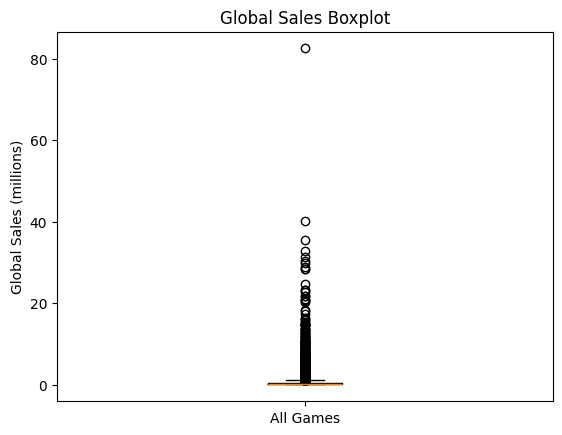

In [ ]:
# Boxplot for global sales
plt.boxplot(df_cleaned['Global_Sales'])
plt.title("Global Sales Boxplot")
plt.ylabel("Global Sales (millions)")
plt.xticks([1], ["All Games"])
plt.show()


#### Global Sales (Boxplot)
- Most games sell very few units (global sales clustered near zero).
- A handful of big outliers — e.g. Wii Sports (~82M), Mario Kart, etc.
- This is normal: video game sales follow a long-tail distribution.

Outliers exist but they are legitimate top-sellers, not data errors


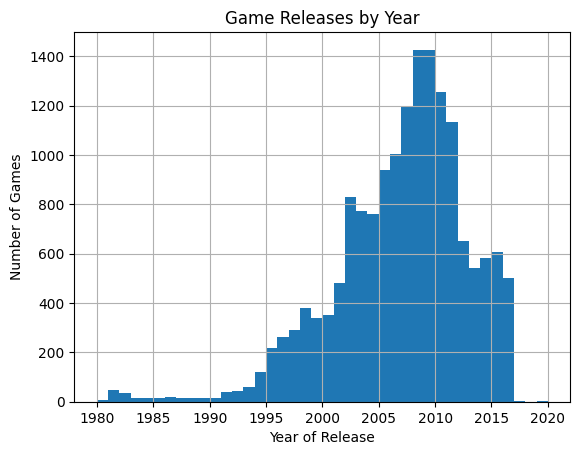

In [49]:
# Year distribution (ignoring -1)
df_cleaned[df_cleaned['Year_of_Release']>0]['Year_of_Release'].hist(bins=40)
plt.title("Game Releases by Year")
plt.xlabel("Year of Release")
plt.ylabel("Number of Games")
plt.show()

#### Game Releases by Year (Histogram)
- Clean trend: almost no releases pre-1990, big rise mid-90s onward.
- Clear peak between around 2005 and 2010 (PS2/Wii/DS/360 era)
- Drop after 2015, This is likely due to the dataset being incomplete for recent year or alternatively it could indicate an industry shift.

Overall the year trend looks realistic.

In [46]:
df_cleaned.nlargest(10, 'Global_Sales')[['Name','Platform','Global_Sales']]

,Name,Platform,Global_Sales
0,Wii Sports,Wii,82.53
1,Super Mario Bros.,NES,40.24
2,Mario Kart Wii,Wii,35.52
3,Wii Sports Resort,Wii,32.77
4,Pokemon Red/Pokemon Blue,GB,31.37
5,Tetris,GB,30.26
6,New Super Mario Bros.,DS,29.80
7,Wii Play,Wii,28.92
8,New Super Mario Bros. Wii,Wii,28.32
9,Duck Hunt,NES,28.31


#### Top 10 Global Sellers
- These are well known top sellers
- There are no suspicious/unexpected values such as 9999M

### **Overall Conclusions**

I systematically validated the **`video_game_sales_cleaned.csv`** dataset to ensure it is reliable for analysis and visualisation.  
Our checks covered file structure, schema, missing values, logical consistency, duplicates, and outlier inspection.

### **Key Outcomes**
- **Structure & Schema:** The CSV loaded without errors; column names are clear, and data types are correct (floats for sales, integers for years, strings for categories).  
- **Completeness & Validity:** No missing values across columns. No negative or obviously incorrect sales figures.  
- **Year Values:** ~269 rows use `-1` as a placeholder for unknown release years. This is fine for completeness but should be excluded or treated as missing when doing time-based analysis.  
- **Sales Consistency:** `Global_Sales` aligns with the sum of regional sales within a very small rounding tolerance (<0.02M units).  
- **Duplicates:** Only 4 duplicated game/platform entries found. These can be manually reviewed or dropped if a one-row-per-title format is needed.  
- **Outliers & Trends:** Extremely high-selling games (e.g., Wii Sports, Mario Kart Wii) are legitimate; no unrealistic spikes. Yearly release trends match industry history.  
- **Categories:** Platform, Genre, Publisher, and Developer values appear valid and consistent.

### **Broader Impact**
Because the other CSV files in this project were created from this validated source file, their structural and logical integrity is also effectively confirmed. They inherit the same clean schema and data quality checks performed here.

### **Assessment**
The dataset is **high-quality and analysis-ready**.  
Only minimal caveats remain:
- Filter or replace placeholder years (`-1`) for any time-series visuals or year-based calculations.  
- Review or merge the few duplicate entries where the same game/platform appears more than once.


---